不使用reconstruction loss的条件变分自编码器生成MNIST数据
===

In [6]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_classes = 10
num_features = 784
num_hidden_1 = 500
num_latent = 35

Device: cuda:0


# 2.导入数据

In [8]:
train_dataset = datasets.MNIST(root='/input/MNIST/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='/input/MNIST/', 
                              train=False, 
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# 3.模型

In [9]:
def to_onehot(labels, num_classes, device):

    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot


class ConditionalVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        
        self.num_classes = num_classes
        
        ### ENCODER
        self.hidden_1 = torch.nn.Linear(num_features+num_classes, num_hidden_1)
        self.z_mean = torch.nn.Linear(num_hidden_1, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(num_hidden_1, num_latent)
        
        
        ### DECODER
        self.linear_3 = torch.nn.Linear(num_latent+num_classes, num_hidden_1)
        # don't output labels in resulting image as it yields worse results
        #self.linear_4 = torch.nn.Linear(num_hidden_1, num_features+num_classes)
        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features)

    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        x = torch.cat((features, onehot_targets), dim=1)

        ### ENCODER
        x = self.hidden_1(x)
        x = F.leaky_relu(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        ### DECODER
        x = self.linear_3(encoded)
        x = F.leaky_relu(x)
        x = self.linear_4(x)
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features,
                                          num_hidden_1,
                                          num_latent,
                                          num_classes)
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# 4.训练

In [10]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features, targets)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        ### Add condition
        # Disabled for reconstruction loss as it gives poor results
        # x_con = torch.cat((features, to_onehot(targets, num_classes, device)), dim=1)
        
        ### Compute loss
        # pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        ### UPDATE MODEL PARAMETERS
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/469 | Cost: 70192.2188
Epoch: 001/050 | Batch 050/469 | Cost: 25749.1211
Epoch: 001/050 | Batch 100/469 | Cost: 21997.0703
Epoch: 001/050 | Batch 150/469 | Cost: 19867.7812
Epoch: 001/050 | Batch 200/469 | Cost: 19859.0391
Epoch: 001/050 | Batch 250/469 | Cost: 18637.0820
Epoch: 001/050 | Batch 300/469 | Cost: 17863.7227
Epoch: 001/050 | Batch 350/469 | Cost: 16945.8711
Epoch: 001/050 | Batch 400/469 | Cost: 16601.5820
Epoch: 001/050 | Batch 450/469 | Cost: 16566.0957
Time elapsed: 0.34 min
Epoch: 002/050 | Batch 000/469 | Cost: 15996.6504
Epoch: 002/050 | Batch 050/469 | Cost: 15971.1006
Epoch: 002/050 | Batch 100/469 | Cost: 15841.2734
Epoch: 002/050 | Batch 150/469 | Cost: 15799.8740
Epoch: 002/050 | Batch 200/469 | Cost: 15457.3789
Epoch: 002/050 | Batch 250/469 | Cost: 15050.9346
Epoch: 002/050 | Batch 300/469 | Cost: 14811.6445
Epoch: 002/050 | Batch 350/469 | Cost: 15051.6934
Epoch: 002/050 | Batch 400/469 | Cost: 14692.3350
Epoch: 002/050 | Batch 450/

Epoch: 016/050 | Batch 350/469 | Cost: 12730.2480
Epoch: 016/050 | Batch 400/469 | Cost: 12666.8486
Epoch: 016/050 | Batch 450/469 | Cost: 12713.0420
Time elapsed: 5.25 min
Epoch: 017/050 | Batch 000/469 | Cost: 13198.5527
Epoch: 017/050 | Batch 050/469 | Cost: 13019.5332
Epoch: 017/050 | Batch 100/469 | Cost: 12890.5859
Epoch: 017/050 | Batch 150/469 | Cost: 12778.2500
Epoch: 017/050 | Batch 200/469 | Cost: 12663.4150
Epoch: 017/050 | Batch 250/469 | Cost: 13064.8164
Epoch: 017/050 | Batch 300/469 | Cost: 12198.5576
Epoch: 017/050 | Batch 350/469 | Cost: 12886.2422
Epoch: 017/050 | Batch 400/469 | Cost: 12956.2539
Epoch: 017/050 | Batch 450/469 | Cost: 12548.4629
Time elapsed: 5.58 min
Epoch: 018/050 | Batch 000/469 | Cost: 12395.5254
Epoch: 018/050 | Batch 050/469 | Cost: 12679.2383
Epoch: 018/050 | Batch 100/469 | Cost: 12541.4512
Epoch: 018/050 | Batch 150/469 | Cost: 13454.2090
Epoch: 018/050 | Batch 200/469 | Cost: 12877.9746
Epoch: 018/050 | Batch 250/469 | Cost: 12641.6758
Epoc

Epoch: 032/050 | Batch 200/469 | Cost: 12586.3906
Epoch: 032/050 | Batch 250/469 | Cost: 12634.0938
Epoch: 032/050 | Batch 300/469 | Cost: 12623.0781
Epoch: 032/050 | Batch 350/469 | Cost: 12794.3105
Epoch: 032/050 | Batch 400/469 | Cost: 12322.6055
Epoch: 032/050 | Batch 450/469 | Cost: 11961.3711
Time elapsed: 10.48 min
Epoch: 033/050 | Batch 000/469 | Cost: 12261.5068
Epoch: 033/050 | Batch 050/469 | Cost: 12233.7148
Epoch: 033/050 | Batch 100/469 | Cost: 12171.5879
Epoch: 033/050 | Batch 150/469 | Cost: 12440.9746
Epoch: 033/050 | Batch 200/469 | Cost: 12394.9971
Epoch: 033/050 | Batch 250/469 | Cost: 12243.0039
Epoch: 033/050 | Batch 300/469 | Cost: 12494.4922
Epoch: 033/050 | Batch 350/469 | Cost: 12197.9160
Epoch: 033/050 | Batch 400/469 | Cost: 12483.5850
Epoch: 033/050 | Batch 450/469 | Cost: 12837.4688
Time elapsed: 10.81 min
Epoch: 034/050 | Batch 000/469 | Cost: 12422.2490
Epoch: 034/050 | Batch 050/469 | Cost: 12801.8984
Epoch: 034/050 | Batch 100/469 | Cost: 12483.5684
Ep

Epoch: 048/050 | Batch 050/469 | Cost: 12669.6445
Epoch: 048/050 | Batch 100/469 | Cost: 12354.6514
Epoch: 048/050 | Batch 150/469 | Cost: 11646.0137
Epoch: 048/050 | Batch 200/469 | Cost: 12011.7168
Epoch: 048/050 | Batch 250/469 | Cost: 12221.5107
Epoch: 048/050 | Batch 300/469 | Cost: 12706.4766
Epoch: 048/050 | Batch 350/469 | Cost: 12421.1875
Epoch: 048/050 | Batch 400/469 | Cost: 12177.4062
Epoch: 048/050 | Batch 450/469 | Cost: 13165.4082
Time elapsed: 14.34 min
Epoch: 049/050 | Batch 000/469 | Cost: 12124.2500
Epoch: 049/050 | Batch 050/469 | Cost: 12283.2441
Epoch: 049/050 | Batch 100/469 | Cost: 12019.9121
Epoch: 049/050 | Batch 150/469 | Cost: 12357.6426
Epoch: 049/050 | Batch 200/469 | Cost: 12515.0527
Epoch: 049/050 | Batch 250/469 | Cost: 12296.8281
Epoch: 049/050 | Batch 300/469 | Cost: 12361.1309
Epoch: 049/050 | Batch 350/469 | Cost: 12231.4619
Epoch: 049/050 | Batch 400/469 | Cost: 12505.1113
Epoch: 049/050 | Batch 450/469 | Cost: 12450.4248
Time elapsed: 14.54 min
Ep

# 5.评估

## 5.1.重构

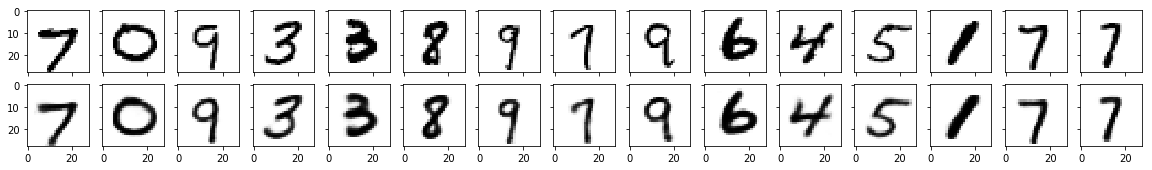

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

## 5.2.生成

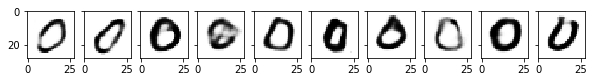

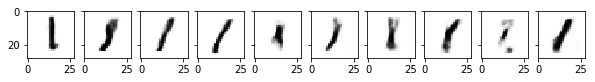

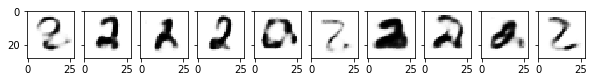

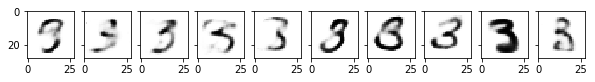

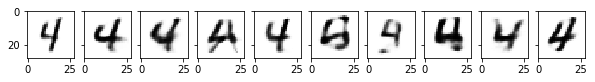

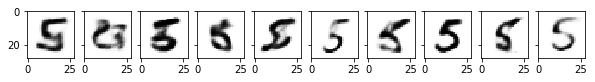

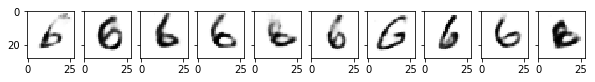

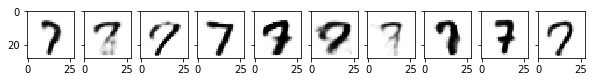

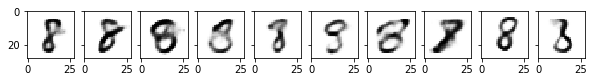

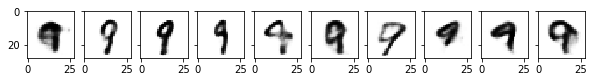

In [13]:
for i in range(10):

    ##########################
    ### RANDOM SAMPLE
    ##########################    
    
    labels = torch.tensor([i]*10).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features, labels)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]

    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')